In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/emotion/text_emotion.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Loading Dataset

In [2]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv',delimiter=',', encoding='ISO-8859-1')
df.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
df.shape

(1048572, 6)

# Data Cleaning and EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   polarity of tweet   1048572 non-null  int64 
 1   id of the tweet     1048572 non-null  int64 
 2   date of the tweet   1048572 non-null  object
 3   query               1048572 non-null  object
 4   user                1048572 non-null  object
 5   text of the tweet   1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [5]:
df.isnull().sum()

polarity of tweet     0
id of the tweet       0
date of the tweet     0
query                 0
user                  0
text of the tweet     0
dtype: int64

There's no null values that's good for us

In [6]:
#Now Let's drop the columns we don't need!
df.drop(['id of the tweet', 'date of the tweet', 'query', 'user'], axis=1, inplace=True)
df.head()

,polarity of tweet,text of the tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [7]:
#Simplifying the names of columns
df.columns = ['sentiment', 'text']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1048572 non-null  int64 
 1   text       1048572 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


In [9]:
df['sentiment'].value_counts()

sentiment
0    799996
4    248576
Name: count, dtype: int64

# Text Preprocessing

In [12]:
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()
corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

1048572
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [13]:
final_corpus = []
final_corpus_joined = []
for i in df.index:
    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    text = text.split()
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

In [14]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["sentiment"] = df["sentiment"].values

In [15]:
data_cleaned

,text,sentiment
0,upset updat facebook text might cri result sch...,0
1,kenichan dive mani time ball manag save rest g...,0
2,whole bodi feel itchi like fire,0
3,nationwideclass behav mad see,0
4,kwesidei whole crew,0
...,...,...
1048567,grandma make dinenr mum,4
1048568,mid morn snack time bowl chees noodl yum,4
1048569,shadela say like termini movi come like word,4
1048570,destinyhop im great thaank wbuu,4


In [16]:
#This df is created for wordcloud only
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df['sentiment'].values
data_eda.head()

,text,sentiment
0,"[upset, updat, facebook, text, might, cri, res...",0
1,"[kenichan, dive, mani, time, ball, manag, save...",0
2,"[whole, bodi, feel, itchi, like, fire]",0
3,"[nationwideclass, behav, mad, see]",0
4,"[kwesidei, whole, crew]",0


# Word Cloud

In [17]:
positive = data_eda[data_eda['sentiment'] == 4]
positive_list = positive['text'].tolist()
negative = data_eda[data_eda['sentiment'] == 0]
negative_list = negative['text'].tolist()

In [18]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

# Model Building

In [21]:
X = data_cleaned['text']
y = data_cleaned['sentiment']

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()
Xt = tfid.fit_transform(X)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state= 42)

**Logistic Regression**

In [24]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [25]:
y_pred = model.predict(X_test)

In [26]:
#Showing Model Summary
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90    160130
           4       0.73      0.46      0.57     49585

    accuracy                           0.83    209715
   macro avg       0.79      0.70      0.73    209715
weighted avg       0.82      0.83      0.82    209715



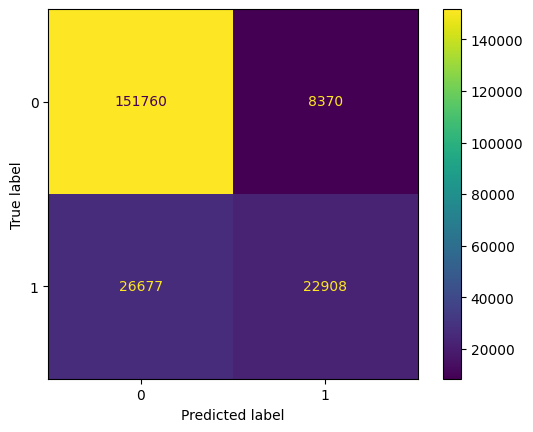

In [27]:
#Visualizing Model Results
t1 = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
t1.plot()